In [2]:
import os, sys
import cv2
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt

def get_data_from_file(train_file):
  train_data = []
  # enter your code here (7 points)
  with open(train_file) as fp:
    lines = fp.readlines()  # read all lines
  for k, line in enumerate(lines):  # trace from each line
    # (第幾個, 總共有幾個)
    print('{:6d} /{:6d}'.format(k+1, len(lines)), end='\r')
    # obtain img_path from line (make sure that your img_path is correct)
    try:
      root = './dogs_and_cats/train/' # determine the root path depending on your environment
      img_path = root + line.strip()
      img = cv2.imread(img_path)
      img_resized = cv2.resize(img, (48, 48)) # (48, 48, 3)
      # if line contains cat  
      if 'cat' in line:
        label = 0
      # if line contains dog
      if 'dog' in line:
        label = 1
      train_data.append([img_resized, label])
    except Exception as e:
      # print error message
      print(f"Error happened in {img_path}: {e}")
  return train_data

def get_image_and_label(train_data):
  # enter your code here (8 points)
  num_X = len(train_data)
  X_train = []
  Y_train = []
  for img, label in train_data:
    X_train.append(img)
    Y_train.append(label)

  X_train = np.array(X_train, dtype=np.uint8).reshape((num_X, 48, 48, 3))
  Y_train = np.array(Y_train, dtype=np.uint8).reshape((num_X))

  return X_train, Y_train

def assignment4b_1():
  train_file = 'train_list.txt'
  test_file = 'test_list.txt'
  train_data = get_data_from_file(train_file)
  X_train, Y_train = get_image_and_label(train_data)
  print()  
  test_data = get_data_from_file(test_file)
  X_test, Y_test = get_image_and_label(test_data)
  print()
  print(len(train_data))
  print(train_data[0][0].shape)
  print(len(test_data))
  print(test_data[0][0].shape)

  save_path = 'dogs_cats.pkl'
  print('Saving to', save_path)
  data = {}
  data['X_train'] = X_train
  data['Y_train'] = Y_train
  data['X_test'] = X_test
  data['Y_test'] = Y_test
  pickle.dump(data, open(save_path, 'wb'))

def build_model():
  # enter your code here, and remove the following pass (15 points)
  height, width = 48, 48
  inputs = tf.keras.Input((height, width, 3))
  x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(2, activation='softmax')(x)
  outputs = x
  return tf.keras.Model(inputs = inputs, outputs = outputs)

def assignment4b_2():
  # load data and normalized
  data = pickle.load(open("dogs_cats.pkl","rb"))
  X_train, Y_train, X_test, Y_test = data["X_train"], data["Y_train"], data["X_test"], data["Y_test"]
  X_train = X_train / 255.0
  X_test = X_test / 255.0
  # create the model
  model = build_model()
  model.summary()
  model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  ck_dir = "ckpt_dogcat"
  checkpoint_path = ck_dir+"/cp-{epoch:04d}.ckpt"
  cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, save_freq='epoch')
  batch_size = 64
  epochs = 60
  # enter your code here (5 points)
  # fit the model
  history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], validation_split=0.1, shuffle=True)
  # display the test accuracy of the trained model on(X_test, Y_test)
  test_loss, test_acc = model.evaluate(X_test, Y_test)
  print(f"Test accuracy: {test_acc:.4f}")
  # Use pickle.dump() to save history.history in 'history.pkl' in binary encodings.
  pickle.dump(history.history, open('history.pkl', 'wb'))
    
def assignment4b_3():
  # enter your code here, and remove the following pass (5 points)
  print("In assignment4b_3")
  # Use pickle.load() to load 'history.pkl' in the variable history.
  with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

    # Plot training/validation accuracy vs. epochs as in the left figure below.
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.legend()

    plt.subplot(1,2,2)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()

    plt.show()

def assignment4b_4():
  # enter your code here, and remove the following pass (5 points)
  print("In assignment4b_4")
  # Display the test accuracy on (X_test, Y_test) for epoch 10, 20, …, 60.
  weight_paths = [
                    'ckpt_dogcat/cp-0010.ckpt', 
                    'ckpt_dogcat/cp-0020.ckpt', 
                    'ckpt_dogcat/cp-0030.ckpt', 
                    'ckpt_dogcat/cp-0040.ckpt',
                    'ckpt_dogcat/cp-0050.ckpt',
                    'ckpt_dogcat/cp-0060.ckpt'
                  ]
  
  # prepare the model
  model = build_model()
  model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  # load the data
  data = pickle.load(open("dogs_cats.pkl","rb"))
  X_train, Y_train, X_test, Y_test = data["X_train"], data["Y_train"], data["X_test"], data["Y_test"]
  X_train = X_train / 255.0
  X_test = X_test / 255.0

  loss_list = []
  acc_list = []
  for weight_path in weight_paths:
    model.load_weights(weight_path)
    loss, acc = model.evaluate(X_test, Y_test)
    print(f'Current weight{weight_path} for test accuracy: {acc}')
    
    loss_list.append(loss)
    acc_list.append(acc)

  # draw variation
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Test Accuracy')
  plt.plot([10, 20, 30, 40, 50, 60], acc_list, marker='o', label='Test Accuracy')
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Test Loss')
  plt.plot([10, 20, 30, 40, 50, 60], loss_list, marker='o', label='Test Loss')
  plt.grid()

  plt.tight_layout()
  plt.show()


In [3]:
if __name__ == '__main__':
    assignment4b_1() # do not modify this line

 20000 / 20000
  5000 /  5000
20000
(48, 48, 3)
5000
(48, 48, 3)
Saving to dogs_cats.pkl


In [4]:
    assignment4b_2() # do not modify this line

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248  

In assignment4b_3


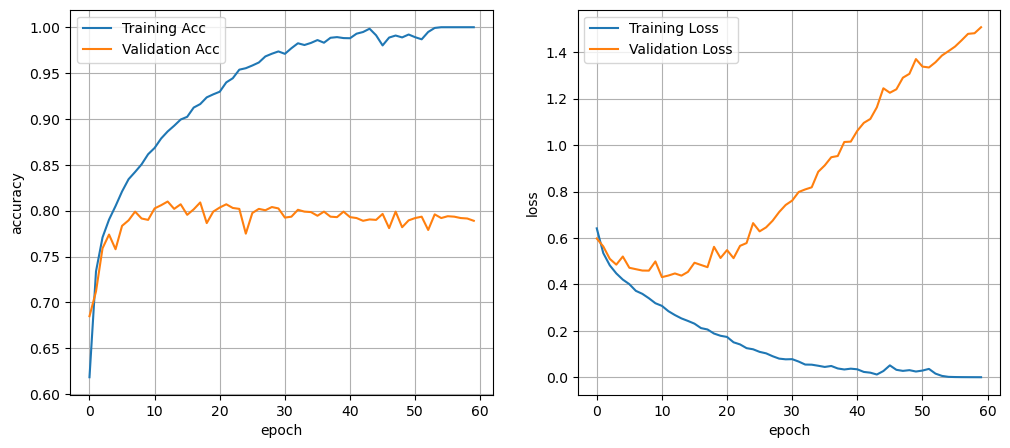

In [5]:
    assignment4b_3() # do not modify this line

In assignment4b_4
157/157 [==============================] - 4s 18ms/step - loss: 0.4480 - accuracy: 0.8040
Current weightckpt_dogcat/cp-0010.ckpt for test accuracy: 0.8040000200271606
157/157 [==============================] - 3s 18ms/step - loss: 0.4702 - accuracy: 0.8274
Current weightckpt_dogcat/cp-0020.ckpt for test accuracy: 0.8274000287055969
157/157 [==============================] - 3s 17ms/step - loss: 0.6397 - accuracy: 0.8256
Current weightckpt_dogcat/cp-0030.ckpt for test accuracy: 0.8256000280380249
157/157 [==============================] - 3s 16ms/step - loss: 0.9255 - accuracy: 0.8174
Current weightckpt_dogcat/cp-0040.ckpt for test accuracy: 0.8173999786376953
157/157 [==============================] - 3s 17ms/step - loss: 1.2495 - accuracy: 0.8096
Current weightckpt_dogcat/cp-0050.ckpt for test accuracy: 0.8095999956130981
157/157 [==============================] - 3s 18ms/step - loss: 1.3523 - accuracy: 0.8198
Current weightckpt_dogcat/cp-0060.ckpt for test accuracy:

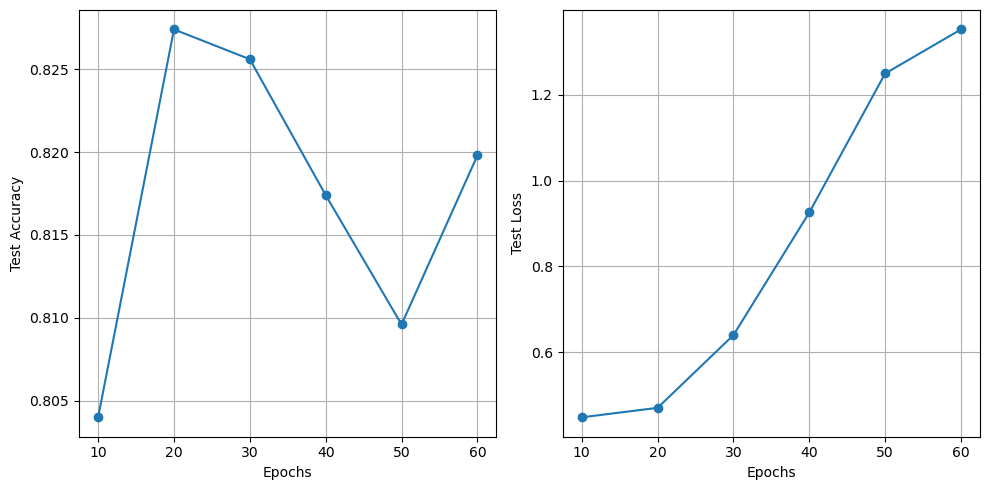

In [6]:
    assignment4b_4() # do not modify this line

In [ ]:
# Question 1 (5 points): If we set shuffle=False during the execution of model.fit() in Assignment 4b-2,
# which was previously set to shuffle=True, what impact will this have on the validation accuracy?
# Write down your answer here.

# [ref]: https://stats.stackexchange.com/questions/245502/why-should-we-shuffle-data-while-training-a-neural-network
# [Answer]: By setting shuffle=true, we can avoid the model to bad learning,
# which means that the model can learn better and will not stuck in a local minimum.
# Also, By setting shuffle=True, we allow the training data to be presented in a random order for each epoch.
# If we set shuffle=False, the model will see the data in the same order for each epoch,
# which may lead to overfitting and poor generalization.

# Therefore, if we set shuffle=False, the validation accuracy are expected be lower than that of shuffle=True.

# The experiment are shown below, which shows that by setting shuffle = false,
# the validation accuracy is a bits lower than that of shuffle = true.
# Note: This experiment only trains for 10 epochs for the simple test.

In [ ]:
data = pickle.load(open("dogs_cats.pkl","rb"))
X_train, Y_train, X_test, Y_test = data["X_train"], data["Y_train"], data["X_test"], data["Y_test"]
X_train = X_train / 255.0
X_test = X_test / 255.0
model = build_model()
model.summary()
model.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
ck_dir = "ckpt_dogcat"
checkpoint_path = ck_dir+"/cp-{epoch:04d}.ckpt"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, save_freq='epoch')
batch_size = 64
epochs = 10
# enter your code here (5 points)
# fit the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, callbacks=[cp_callback], validation_split=0.1, shuffle=False)
# display the test accuracy of the trained model on(X_test, Y_test)
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.4f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        9248

In [ ]:
# Question 2 (5 points): In Assignment 4b-4, what epoch yields the highest test accuracy, and what is the reason for this?
# Write down your answer here.

# [Answer]: The epoch 20 yields the highest test accuracy, which is 0.8274000287055969.
# 雖然根據 assignment 4b-3 的圖表顯示，隨者 epoch 的增加，訓練的準確率會上升，但驗證集的準確率趨近穩定，
# 而根據 assignment 4b-4 的圖表顯示經過測試不同 epoch 所儲存的權重模型在測試集上的表現，test loss 會有越來越高的趨勢，
# 因此我認為是因為模型只是在訓練集上表現良好，並沒有學到完整的泛化能力，因此才在　epoch 20 的時候得到較好的準確率。